# 04 Hyperparameter tuning

In this notebook we tune the hyperparameters of the models to maximize their performance.

## Reading data

We read the preprocessed data from the pickle file we created in step 03.

In [1]:
# Basic packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Catboost
import catboost
from catboost import CatBoostRegressor
from catboost import Pool

# XGBoost
from xgboost import XGBRegressor
from xgboost import plot_importance

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Linear regression
from sklearn.linear_model import LinearRegression

# Linear SVR
from sklearn.svm import LinearSVR

# Utils
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import pickle
import time
import itertools

In [2]:
file = open('data/processed-data.pickle', 'rb')
data = pickle.load(file)

X_train = data['X_train']
y_train = data['y_train']
X_validation = data['X_validation']
y_validation = data['y_validation']
X_test = data['X_test']
test = data['test']

## Feature selection

In [3]:
# Fixed hyperparameters for feature selection
n_estimators = 20
max_depth = 5

base_features = ['shop_id', 'item_id', 'item_cnt']

rf_feature_groups = [
    ['mean_item_cnt'],
    ['transactions'],
    ['year', 'month'],
    ['item_cnt_prev_month_1', 'item_cnt_prev_month_2', 'item_cnt_prev_month_3'],
    ['item_cnt_prev_min', 'item_cnt_prev_max'],
    ['item_cnt_prev_mean', 'item_cnt_prev_std'],
    ['item_trend'],
    ['shop_mean', 'item_mean', 'shop_item_mean', 'year_mean']
]

rf_feature_errors = []

In [66]:
i = 0

print('Training...')
for n in range(1, 3):
    for comb in itertools.combinations(rf_feature_groups, n):
        i += 1
        print(i, end='\n' if i%20 == 0 else ' ')

        rf_features = base_features + [feature for feature_gp in comb for feature in feature_gp]

        rf_train = X_train[rf_features]
        rf_val = X_validation[rf_features]
        rf_test = X_test[rf_features]

        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=0
        )

        rf_model.fit(rf_train, y_train)

        rf_preds = rf_model.predict(rf_val)
        rf_error = np.sqrt(mean_squared_error(y_validation, rf_preds))

        rf_feature_errors.append([rf_features, rf_error])

Training...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 

[Text(0, 1, 'mean_item_cnt'),
 Text(1, 1, 'transactions'),
 Text(2, 1, 'year'),
 Text(3, 1, 'item_cnt_prev_month_1'),
 Text(4, 1, 'item_cnt_prev_min'),
 Text(5, 1, 'item_cnt_prev_mean'),
 Text(6, 1, 'item_trend'),
 Text(7, 1, 'shop_mean')]

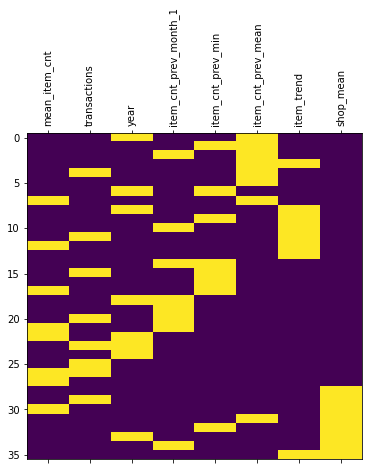

In [110]:
performances = pd.DataFrame(rf_feature_errors, columns=['features', 'error']).sort_values(by='error')

for feature_gp in rf_feature_groups:
    performances[feature_gp[0]] = performances['features'].apply(lambda features: set(feature_gp) <= set(features))

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(performances.drop(['features', 'error'], axis=1), aspect='auto')
ax.set_xticks(range(8))
ax.set_xticklabels([feature_gp[0] for feature_gp in rf_feature_groups], rotation = 90)

We decide to exclude the groups of features which perform worse. In this case, we drop the following features:
* mean_item_cnt
* transactions
* shop_mean
* item_mean
* shop_item_mean
* year_mean

## Random Forest

In [106]:
rf_features = base_features + ['year', 'month', 'item_cnt_prev_month_1', 'item_cnt_prev_month_2', 'item_cnt_prev_month_3', 'item_cnt_prev_min', 'item_cnt_prev_max', 'item_cnt_prev_mean', 'item_cnt_prev_std', 'item_trend']

rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [117]:
rf_hyperparam_grid = {
    'n_estimators': [20, 40, 60],
    'max_depth': [7, 9, 11]
}

rf_models = {}

In [118]:
# Iterate over all combinations of hyperparameters
for params in ParameterGrid(rf_hyperparam_grid):
    # Unique model identifier
    key = str(params['n_estimators']) + 'x' + str(params['max_depth'])

    # Don't retrain if already trained
    if key in rf_models:
        continue

    # Initialization with given hyperparameters
    print('Training', key, end='...')
    rf_models[key] = {
        'model': RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            random_state=0
        )
    }

    # Training
    t = time.time()
    rf_models[key]['model'].fit(rf_train, y_train)
    rf_models[key]['time'] = time.time() - t
    print('Time:', round(rf_models[key]['time'], 2), 's', end='. ')

    # Validation
    rf_models[key]['preds'] = rf_models[key]['model'].predict(rf_val)
    rf_models[key]['error'] = np.sqrt(mean_squared_error(y_validation, rf_models[key]['preds']))
    print('Error:',  round(rf_models[key]['error'], 4))

Training 20x7...Time: 105.96 s. Error: 1.0101
Training 40x7...Time: 206.99 s. Error: 1.0099
Training 60x7...Time: 313.1 s. Error: 1.0099
Training 20x9...Time: 124.74 s. Error: 1.008
Training 40x9...Time: 252.1 s. Error: 1.0073
Training 60x9...Time: 375.14 s. Error: 1.0073
Training 20x11...Time: 149.51 s. Error: 1.0104
Training 40x11...Time: 292.81 s. Error: 1.009
Training 60x11...Time: 433.86 s. Error: 1.0091


In [8]:
def plot_heatmap(models, hyperparam_grid, field):
    hyperparams = list(hyperparam_grid.keys())

    values = pd.DataFrame(index=hyperparam_grid[hyperparams[0]][::-1], columns=hyperparam_grid[hyperparams[1]], dtype='float64')
    for params in ParameterGrid(hyperparam_grid):
        key = str(params[hyperparams[0]]) + 'x' + str(params[hyperparams[1]])
        values.loc[params[hyperparams[0]], params[hyperparams[1]]] = models[key][field]

    sns.heatmap(values, annot=True, fmt='.4f', cmap='coolwarm')
    plt.xlabel(hyperparams[1])
    plt.ylabel(hyperparams[0])

In [ ]:
plot_heatmap(rf_models, rf_hyperparam_grid, 'error')

In [120]:
# Choose best based on least error
rf_errors = {key: rf_models[key]['error'] for key in rf_models}
rf_best = rf_models[min(rf_errors, key=rf_errors.get)]

# Generate predictions for submission
rf_test_pred = rf_best['model'].predict(rf_test)

## Catboost

In [6]:
cb_features = base_features + ['year', 'month', 'item_cnt_prev_month_1', 'item_cnt_prev_month_2', 'item_cnt_prev_month_3', 'item_cnt_prev_min', 'item_cnt_prev_max', 'item_cnt_prev_mean', 'item_cnt_prev_std', 'item_trend']

cb_train = X_train[cb_features]
cb_val = X_validation[cb_features]
cb_test = X_test[cb_features]

In [7]:
# Specify indices for categorical features: shop_id, item_id, year and month
cb_cat_features = [0, 1, 3, 4]

cb_hyperparam_grid = {
    'depth': [2, 3, 4, 5],
    'max_ctr_complexity': [3, 5, 7, 9]
}

cb_models = {}

In [8]:
# Iterate over all combinations of hyperparameters
for params in ParameterGrid(cb_hyperparam_grid):
    # Unique model identifier
    key = str(params['depth']) + 'x' + str(params['max_ctr_complexity'])

    # Don't retrain if already trained
    if key in cb_models:
        continue

    # Initialization with given hyperparameters
    print('Training', key, end='...')
    cb_models[key] = {
        'model': CatBoostRegressor(
            depth=params['depth'],
            max_ctr_complexity=params['max_ctr_complexity'],
            od_type='Iter',
            verbose=0,
            random_seed=0
        )
    }

    # Training
    t = time.time()
    cb_models[key]['model'].fit(
        cb_train, y_train,
        cat_features=cb_cat_features,
        eval_set=(cb_val, y_validation)
    )
    cb_models[key]['time'] = time.time() - t
    print('Time:', round(cb_models[key]['time'], 2), 's', end='. ')

    # Validation
    cb_models[key]['preds'] = cb_models[key]['model'].predict(cb_val)
    cb_models[key]['error'] = np.sqrt(mean_squared_error(y_validation, cb_models[key]['preds']))
    print('Error:',  round(cb_models[key]['error'], 4))

Training 2x3...Time: 32.6 s. Error: 1.0199
Training 2x5...Time: 34.9 s. Error: 1.0199
Training 2x7...Time: 36.65 s. Error: 1.0199
Training 2x9...Time: 40.08 s. Error: 1.0199
Training 3x3...Time: 55.8 s. Error: 1.0166
Training 3x5...Time: 51.13 s. Error: 1.0166
Training 3x7...Time: 49.76 s. Error: 1.0166
Training 3x9...Time: 55.63 s. Error: 1.0166
Training 4x3...Time: 42.41 s. Error: 1.0177
Training 4x5...Time: 57.95 s. Error: 1.0175
Training 4x7...Time: 84.99 s. Error: 1.0175
Training 4x9...Time: 94.0 s. Error: 1.0175
Training 5x3...Time: 70.04 s. Error: 1.017
Training 5x5...Time: 74.67 s. Error: 1.02
Training 5x7...Time: 82.04 s. Error: 1.02
Training 5x9...Time: 74.63 s. Error: 1.02


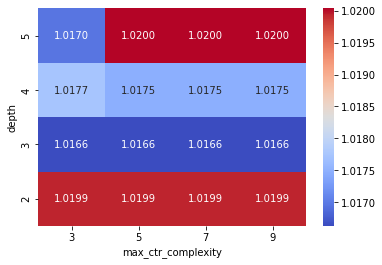

In [11]:
plot_heatmap(cb_models, cb_hyperparam_grid, 'error')

In [12]:
# Choose best based on least error
cb_errors = {key: cb_models[key]['error'] for key in cb_models}
cb_best = cb_models[min(cb_errors, key=cb_errors.get)]

# Generate predictions for submission
cb_test_pred = cb_best['model'].predict(cb_test)

## XGBoost

In [4]:
# Use only part of features on XGBoost.
xgb_features = base_features + ['year', 'month', 'item_cnt_prev_month_1', 'item_cnt_prev_month_2', 'item_cnt_prev_month_3', 'item_cnt_prev_min', 'item_cnt_prev_max', 'item_cnt_prev_mean', 'item_cnt_prev_std', 'item_trend']

xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [5]:
xgb_hyperparam_grid = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 10, 100, 1000]
}

xgb_models = {}

In [6]:
# Iterate over all combinations of hyperparameters
for params in ParameterGrid(xgb_hyperparam_grid):
    # Unique model identifier
    key = str(params['max_depth']) + 'x' + str(params['min_child_weight'])

    # Don't retrain if already trained
    if key in xgb_models:
        continue

    # Initialization with given hyperparameters
    print('Training', key, end='...')
    xgb_models[key] = {
        'model': XGBRegressor(max_depth=8,
                              n_estimators=100,
                              min_child_weight=1000,
                              colsample_bytree=0.7,
                              subsample=0.7,
                              seed=0)
    }

    # Training
    t = time.time()
    xgb_models[key]['model'].fit(xgb_train, y_train)
    xgb_models[key]['time'] = time.time() - t
    print('Time:', round(xgb_models[key]['time'], 2), 's', end='. ')

    # Validation
    xgb_models[key]['preds'] = xgb_models[key]['model'].predict(xgb_val)
    xgb_models[key]['error'] = np.sqrt(mean_squared_error(y_validation, xgb_models[key]['preds']))
    print('Error:',  round(xgb_models[key]['error'], 4))

Training 4x1...Time: 224.47 s. Error: 1.0022
Training 4x10...Time: 206.75 s. Error: 1.0022
Training 4x100...Time: 203.3 s. Error: 1.0022
Training 4x1000...Time: 209.98 s. Error: 1.0022
Training 6x1...Time: 198.58 s. Error: 1.0022
Training 6x10...Time: 203.05 s. Error: 1.0022
Training 6x100...Time: 195.57 s. Error: 1.0022
Training 6x1000...Time: 198.71 s. Error: 1.0022
Training 8x1...Time: 199.87 s. Error: 1.0022
Training 8x10...Time: 196.87 s. Error: 1.0022
Training 8x100...Time: 200.17 s. Error: 1.0022
Training 8x1000...Time: 200.24 s. Error: 1.0022


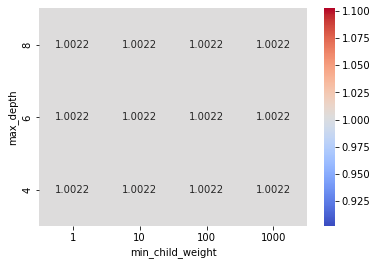

In [9]:
plot_heatmap(xgb_models, xgb_hyperparam_grid, 'error')

In [10]:
# Choose best based on least error
xgb_errors = {key: xgb_models[key]['error'] for key in xgb_models}
xgb_best = xgb_models[min(xgb_errors, key=xgb_errors.get)]

# Generate predictions for submission
xgb_test_pred = xgb_best['model'].predict(xgb_test)

In [25]:
xgb_model = XGBRegressor(max_depth=8,
                         n_estimators=100,
                         min_child_weight=1000,
                         colsample_bytree=0.7,
                         subsample=0.7,
                         seed=0)
xgb_model.fit(xgb_train,
              y_train,
              eval_metric="rmse",
              eval_set=[(xgb_train, y_train), (xgb_val, y_validation)],
              verbose=20,
              early_stopping_rounds=20)

[0]	validation_0-rmse:1.10126	validation_1-rmse:1.10857
[20]	validation_0-rmse:0.93316	validation_1-rmse:1.00206
[40]	validation_0-rmse:0.92834	validation_1-rmse:1.00146
[57]	validation_0-rmse:0.92455	validation_1-rmse:1.00157


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1000, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [26]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [27]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, xgb_val_pred)))

Train rmse: 0.9295267600996537
Validation rmse: 1.001303518160818


## Linear regression

In [143]:
lr_features = ['item_cnt', 'item_cnt_prev_month_1', 'item_trend', 'mean_item_cnt', 'shop_mean']

lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [144]:
# Normalizing
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)

lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [145]:
lr_model = LinearRegression()
lr_model.fit(lr_train, y_train)

LinearRegression()

In [146]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [147]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, lr_val_pred)))

Train rmse: 0.96557127056507
Validation rmse: 1.0128629563995037


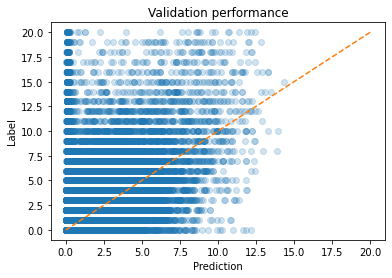

In [148]:
plot_model_performance(lr_val_pred, y_validation, 'Validation performance')

## Linear SVR

In [149]:
lsvr_features = ['item_cnt', 'item_cnt_prev_mean', 'item_cnt_prev_std', 'item_cnt_prev_month_1', 'shop_mean', 'shop_item_mean', 'mean_item_cnt']

lsvr_train = X_train[lsvr_features]
lsvr_val = X_validation[lsvr_features]
lsvr_test = X_test[lsvr_features]

In [150]:
# Normalizing
lsvr_scaler = MinMaxScaler()
lsvr_scaler.fit(lsvr_train)

lsvr_train = lsvr_scaler.transform(lsvr_train)
lsvr_val = lsvr_scaler.transform(lsvr_val)
lsvr_test = lsvr_scaler.transform(lsvr_test)

In [151]:
lsvr_model = LinearSVR()
lsvr_model.fit(lsvr_train, y_train)

LinearSVR(C=1)

In [152]:
lsvr_train_pred = lsvr_model.predict(lsvr_train)
lsvr_val_pred = lsvr_model.predict(lsvr_val)
lsvr_test_pred = lsvr_model.predict(lsvr_test)

In [153]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lsvr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, lsvr_val_pred)))

Train rmse: 1.0018868456518795
Validation rmse: 1.053649239114253


## Ensembling

In [154]:
# Validation data becomes the training data for the ensembling step
X_train_ensembling = pd.DataFrame({
    'catboost': cb_val_pred,
    'xgboost': xgb_val_pred,
    'random_forest': rf_val_pred,
    'linear_regression': lr_val_pred,
    'lsvr': lsvr_val_pred
})

y_train_ensembling = y_validation

In [155]:
# Test data is the test data for the ensembling step
X_test_ensembling = pd.DataFrame({
    'catboost': catboost_test_pred,
    'xgboost': xgb_test_pred,
    'random_forest': rf_test_pred,
    'linear_regression': lr_test_pred,
    'lsvr': lsvr_test_pred
})

In [156]:
ensembling_model = LinearRegression()
ensembling_model.fit(X_train_ensembling, y_train_ensembling)

LinearRegression()

In [157]:
ensemble_train_pred = ensembling_model.predict(X_train_ensembling)
ensemble_test_pred = ensembling_model.predict(X_test_ensembling)

In [158]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_train_pred, y_train_ensembling)))

Train rmse: 1.005152328579565


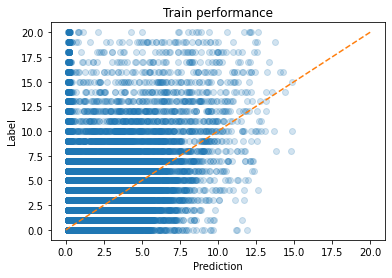

In [159]:
plot_model_performance(ensemble_train_pred, y_train_ensembling, 'Train performance')

## Submission

We finally generate the csv file ready for submission.

In [11]:
def generate_submission_file(data, pred_field, filename='submission.csv'):
    predictions = pd.merge(test, data, on=['shop_id', 'item_id'], how='left').fillna(0)

    output = pd.DataFrame({'ID': predictions['ID'], 'item_cnt_month': predictions[pred_field]})
    output.to_csv('predictions/' + filename, index=False)

In [12]:
X_test['item_cnt_next_month'] = xgb_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'xgboost.csv')

In [161]:
X_test['item_cnt_next_month'] = cb_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'catboost.csv')

X_test['item_cnt_next_month'] = xgb_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'xgboost.csv')

X_test['item_cnt_next_month'] = rf_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'random-forest.csv')

X_test['item_cnt_next_month'] = lr_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'linear-regression.csv')

X_test['item_cnt_next_month'] = lsvr_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'linear-svr.csv')

X_test['item_cnt_next_month'] = ensemble_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'ensemble.csv')